In [ ]:
### Description of variables

'''
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed',
                                    'services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course',
                            'university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output 
     target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after 
     the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be 
     discarded if the intention is to have a realistic predictive model.

# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means 
     client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
'''

In [ ]:
### Additional Definitions:

'''
Euribor is short for Euro Interbank Offered Rate. The Euribor rates are based on the average interest rates 
at which a large panel of European banks borrow funds from one another. There are different maturities, 
ranging from one week to one year.

The Euribor rates are considered to be the most important reference rates in the European money market. 
The interest rates do provide the basis for the price and interest rates of all kinds of financial products 
like interest rate swaps, interest rate futures, saving accounts and mortgages. That’s the exact reason 
why many professionals as well as individuals do monitor the development of the Euribor rates intensively.

-----

Consumer confidence index provides an indication of future developments of households' consumption and saving, 
based upon answers regarding their expected financial situation, their sentiment about the general economic 
situation, unemployment and capability of savings


'''

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re

In [ ]:
# Connect to google drive
in_colab = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/My Drive/Capstone/Project_2")
    in_colab = True
except:
    pass

Mounted at /content/drive


### UML Diagram of Project

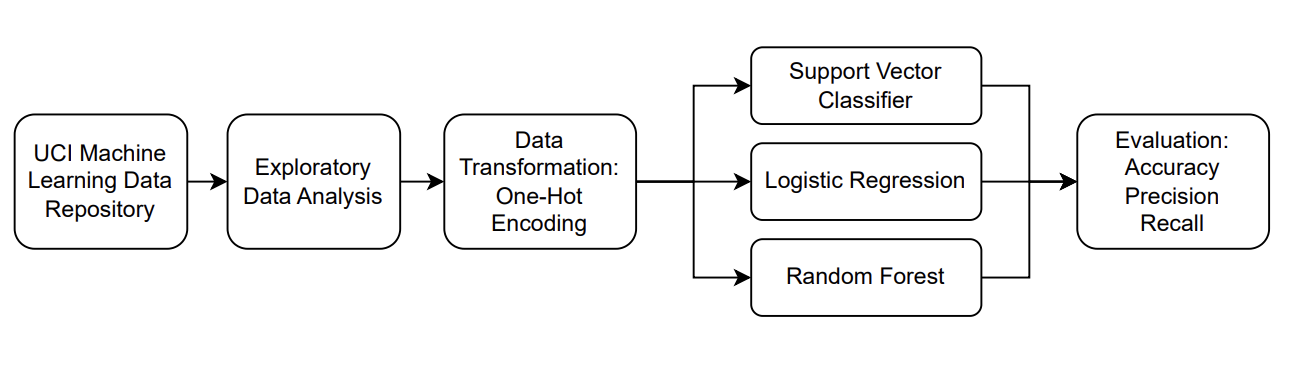

In [ ]:
from IPython.display import Image

display(Image(filename = "Images/UML_Diagram.png"))

### Load Data from Drive

In [ ]:
def load_data():
    # load data from Drive
    filepath = "Data/bank-additional-full.csv"
    raw_df = pd.read_csv(filepath)

    return raw_df


raw_df = load_data()

# as presented is a single column that needs to be split
raw_df.columns

Index(['age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"'], dtype='object')

In [ ]:
raw_df.head(2)

,"age;""job"";""marital"";""education"";""default"";""housing"";""loan"";""contact"";""month"";""day_of_week"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""emp.var.rate"";""cons.price.idx"";""cons.conf.idx"";""euribor3m"";""nr.employed"";""y"""
0,"56;""housemaid"";""married"";""basic.4y"";""no"";""no"";..."
1,"57;""services"";""married"";""high.school"";""unknown..."


In [ ]:
#Initial cleaning to get the data into right tabular form 
def clean_data(raw_df):

    df = raw_df.copy()
    col_names = df.columns
    col_lst = col_names.tolist()[0].split(';')
    col_lst = [re.sub(r'\W+', '', x) for x in col_lst]
    df.columns = ['all']
    new_row_lst = df['all'].str.split(";").to_list()
    clean_df = pd.DataFrame(new_row_lst, columns = col_lst)

    return clean_df


# remove unnecessary quotation marks and replace periods with spaces
def format_columns(df):

    formatted_df = df.copy()
    formatted_df = formatted_df.applymap(lambda x: x.replace('"', ''))
    formatted_df['education'] = formatted_df['education'].apply(lambda x: x.replace('.', ' '))

    return formatted_df


clean_df = clean_data(raw_df)
formatted_df = format_columns(clean_df)
formatted_df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
0,56,housemaid,married,basic 4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [ ]:
# Determine which columns are numeric

for col in formatted_df.columns:
    print(col, formatted_df[col].loc[0])

age 56
job housemaid
marital married
education basic 4y
default no
housing no
loan no
contact telephone
month may
day_of_week mon
duration 261
campaign 1
pdays 999
previous 0
poutcome nonexistent
empvarrate 1.1
conspriceidx 93.994
consconfidx -36.4
euribor3m 4.857
nremployed 5191
y no


In [ ]:
# convert columns to appropriate numeric type
def transform_data_types(df):

    formatted_df = df.copy()

    float_cols = ['empvarrate', 'conspriceidx', 'consconfidx',
        'euribor3m', 'nremployed']

    int_cols = ['age', 'duration',  'pdays', 'campaign',
        'previous']

    # convert to float
    formatted_df[float_cols] = formatted_df[float_cols].astype(float)
    # convert to int
    formatted_df[int_cols] = formatted_df[int_cols].astype(int)

    return formatted_df

formatted_df = transform_data_types(formatted_df)
formatted_df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
0,56,housemaid,married,basic 4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
# investigate numeric columns

formatted_df.describe()

,age,duration,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
# According to source:
# number of contacts performed during this campaign and for this client (numeric, includes last contact)

number_contacts = sorted(formatted_df['campaign'].unique())
print(number_contacts)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 56]


In [ ]:
## Split into successful and unsuccessful samples for investigation
successful_df = formatted_df[formatted_df['y'] == 'yes']
unsuccessful_df = formatted_df[formatted_df['y'] == 'no']

In [ ]:
successful_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
75,41,blue-collar,divorced,basic 4y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university degree,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic 9y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
129,41,technician,married,professional course,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
139,45,blue-collar,married,basic 9y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes


In [ ]:
formatted_df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Evident from the distribution, there is a class imbalance problem, with the number of successful campaigns only accounting for ~ 10% of total data

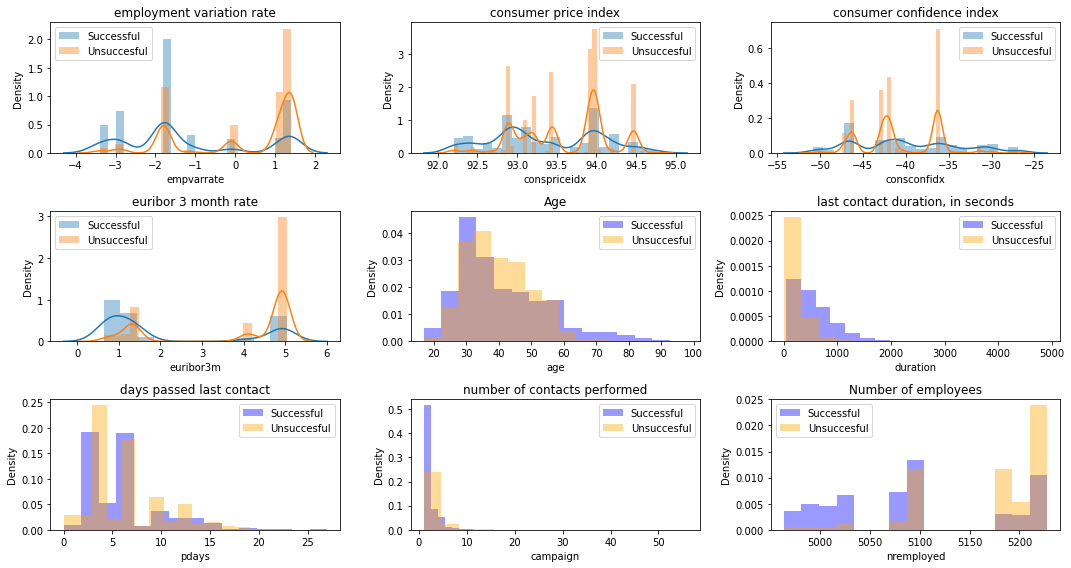

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# visualize the histograms and distributions of each variable in the dataset
def visualize_distributions(successful_df, unsuccessful_df):

    # create subplots needed for each variable
    # at each subplot, plot the data and add the appropriate title and legend
    fig, axes = plt.subplots(3, 3, figsize=(15, 8), sharey=False, tight_layout=True)

    sns.distplot(successful_df['empvarrate'], ax=axes[0, 0], label='Successful')
    sns.distplot(unsuccessful_df['empvarrate'], ax=axes[0, 0], label='Unsuccesful')
    axes[0, 0].set_title("employment variation rate")
    axes[0, 0].legend()

    sns.distplot(successful_df['conspriceidx'], ax=axes[0, 1], label='Successful')
    sns.distplot(unsuccessful_df['conspriceidx'], ax=axes[0, 1], label='Unsuccesful')
    axes[0, 1].set_title("consumer price index")
    axes[0, 1].legend()

    sns.distplot(successful_df['consconfidx'], ax=axes[0, 2], label='Successful')
    sns.distplot(unsuccessful_df['consconfidx'], ax=axes[0, 2], label='Unsuccesful')
    axes[0, 2].set_title("consumer confidence index")
    axes[0, 2].legend()

    sns.distplot(successful_df['euribor3m'], ax=axes[1, 0], label='Successful')
    sns.distplot(unsuccessful_df['euribor3m'], ax=axes[1, 0], label='Unsuccesful')
    axes[1, 0].set_title("euribor 3 month rate")
    axes[1, 0].legend()

    sns.histplot(successful_df['age'], ax=axes[1, 1], label='Successful', 
                stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
    sns.histplot(unsuccessful_df['age'], ax=axes[1, 1], label='Unsuccesful', 
                stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
    axes[1, 1].set_title("Age")
    axes[1, 1].legend()

    sns.histplot(successful_df['duration'], ax=axes[1, 2], label='Successful', 
                stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
    sns.histplot(unsuccessful_df['duration'], ax=axes[1, 2], label='Unsuccesful', 
                stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
    axes[1, 2].set_title("last contact duration, in seconds")
    axes[1, 2].legend()

    sns.histplot(successful_df[successful_df['pdays'] != 999]['pdays'], ax=axes[2, 0], label='Successful', 
                stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
    sns.histplot(unsuccessful_df[unsuccessful_df['pdays'] != 999]['pdays'], ax=axes[2, 0], label='Unsuccesful', 
                stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
    axes[2, 0].set_title("days passed last contact")
    axes[2, 0].legend()

    sns.histplot(successful_df['campaign'], ax=axes[2, 1], label='Successful', 
                stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
    sns.histplot(unsuccessful_df['campaign'], ax=axes[2, 1], label='Unsuccesful', 
                stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
    axes[2, 1].set_title("number of contacts performed")
    axes[2, 1].legend()

    sns.histplot(successful_df['nremployed'], ax=axes[2, 2], label='Successful', 
                stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
    sns.histplot(unsuccessful_df['nremployed'], ax=axes[2, 2], label='Unsuccesful', 
                stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
    axes[2, 2].set_title("Number of employees")
    axes[2, 2].legend()

    # plt.savefig("distributions.png", dpi=100)
    plt.show()

visualize_distributions(successful_df, unsuccessful_df)

In [ ]:
# determine the frequency of jobs that occur in the dataset - separated by y 

counts = pd.DataFrame(formatted_df.groupby('job')['y'].value_counts()).rename(columns={'y':"count"})
counts = counts.reset_index()
counts.head()

,job,y,count
0,admin.,no,9070
1,admin.,yes,1352
2,blue-collar,no,8616
3,blue-collar,yes,638
4,entrepreneur,no,1332


In [ ]:
# determine the frequency of jobs that occur in the dataset regardless of label 

totals = pd.DataFrame(counts.groupby('job')['count'].sum()).rename(columns={'count': 'total'})
totals = totals.reset_index()
totals.head()

,job,total
0,admin.,10422
1,blue-collar,9254
2,entrepreneur,1456
3,housemaid,1060
4,management,2924


In [ ]:
counts = counts.merge(totals, how='left', on='job')
counts.head()

,job,y,count,total
0,admin.,no,9070,10422
1,admin.,yes,1352,10422
2,blue-collar,no,8616,9254
3,blue-collar,yes,638,9254
4,entrepreneur,no,1332,1456


In [ ]:
# calculate percent of individuals who submitted a term deposit grouped by career

yes = counts[counts['y'] == 'yes'].copy()
yes = yes.reset_index(drop=True)
yes = yes.drop('y', axis=1)
yes = yes.rename(columns={"count": 'yes'})

full = yes.copy()
full['no'] = full['total'] - full['yes']
full = full[['job', 'yes', 'no', 'total']]
full['yes_%'] = (full['yes'] / full['total'])*100
full = full.round({'yes_%': 1}).sort_values("yes_%", ascending=False)
full.head()

,job,yes,no,total,yes_%
8,student,275,600,875,31.4
5,retired,434,1286,1720,25.2
10,unemployed,144,870,1014,14.2
0,admin.,1352,9070,10422,13.0
4,management,328,2596,2924,11.2


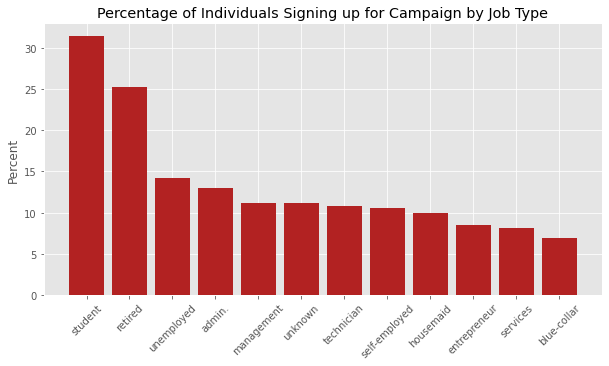

In [ ]:
def plot_career_splits():

    plt.style.use("ggplot")
    plt.figure(figsize=(10,5))

    plt.bar(full['job'], full['yes_%'], color='firebrick')
    plt.xticks(rotation=45)
    plt.title("Percentage of Individuals Signing up for Campaign by Job Type")
    plt.ylabel("Percent")
    # plt.savefig("campaign_success_by_job.png", dpi=100, bbox_inches="tight")
    plt.show()

plot_career_splits()

#### Add Year as a column to the data

In [ ]:
def create_year_col(formatted_df):

    mar_index = formatted_df[formatted_df['month'] == 'mar'].index
    # mar_index

    mar_break_points = [mar_index[i] for i in range(len(mar_index)) if mar_index[i] != mar_index[i-1] + 1]
    first_row_second_year = mar_break_points[0]
    last_row_second_year = mar_break_points[1]

    formatted_df['year'] = 0
    formatted_df['year'][0:first_row_second_year] = 2008
    formatted_df['year'][first_row_second_year:last_row_second_year] = 2009
    formatted_df['year'][last_row_second_year:] = 2010

formatted_df = create_year_col(formatted_df)

In [ ]:
# check different values

formatted_df.isnull().sum() # no null values

formatted_df['day_of_week'].unique() # all valid
formatted_df['education'].unique() # unknown option
formatted_df['marital'].unique() # unknown option

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

### Investigate Categorical Variables

In [ ]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
            'month', 'day_of_week', 'poutcome']

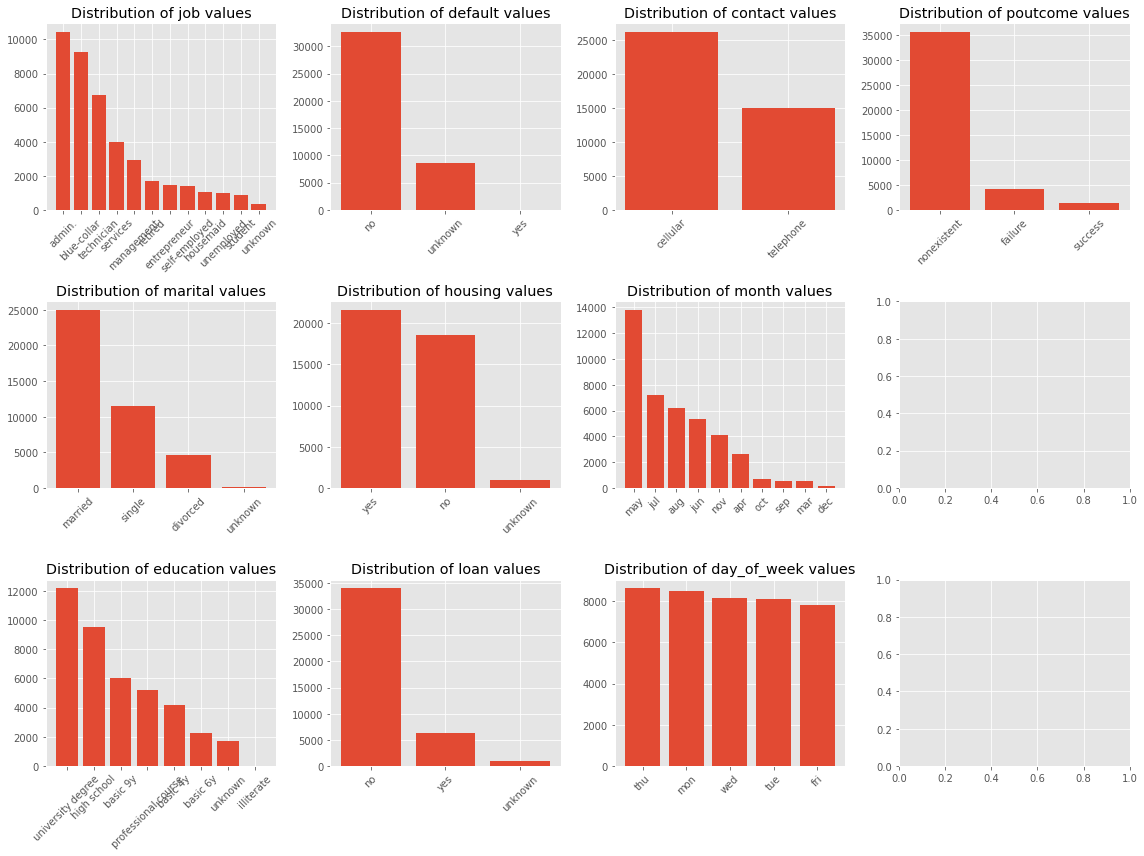

In [ ]:
def plot_variable_counts(formatted_df):

    fig, ax = plt.subplots(3, 4, figsize=(16,12), tight_layout=True)

    i = 0
    j = 0
    for col in cat_cols:

        ax[i, j].bar(formatted_df[col].value_counts().index, formatted_df[col].value_counts())
        ax[i, j].set_xticklabels(formatted_df[col].value_counts().index, rotation=45)
        ax[i, j].set_title(f"Distribution of {col} values")
        
        i += 1
        if i > 2:
            i = 0
            j +=1

    plt.show()

plot_variable_counts(formatted_df)

In [ ]:
# make copy before making alterations to the data
df_copy = formatted_df.copy()

# replace all 'unknown' values with np.nan and drop the np.nan rows
no_unknowns = df_copy.replace('unknown',np.nan).dropna(axis = 0, how = 'any')
no_unknowns.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y,year
0,56,housemaid,married,basic 4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
2,37,services,married,high school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
3,40,admin.,married,basic 6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
4,56,services,married,high school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
6,59,admin.,married,professional course,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008


In [ ]:
print(f"Percent of rows remaining after dropping unknowns: {np.round(len(no_unknowns) / len(formatted_df)*100, 1)}%")

Percent of rows remaining after dropping unknowns: 74.0%


### Convert Categorical Columns to One-Hot Encoded Values

In [ ]:
one_hot_encoded = pd.get_dummies(formatted_df, columns=cat_cols)
one_hot_encoded = one_hot_encoded.drop(cat_cols, axis=1, errors='ignore')
one_hot_encoded.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'empvarrate',
       'conspriceidx', 'consconfidx', 'euribor3m', 'nremployed', 'y', 'year',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic 4y', 'education_basic 6y',
       'education_basic 9y', 'education_high school', 'education_illiterate',
       'education_professional course', 'education_university degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'mo

In [ ]:
one_hot_encoded

,age,duration,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
## Save file to Drive

# one_hot_encoded.to_excel("one_hot.xlsx")

### Old Code

In [ ]:
# formatted_df[formatted_df['month'] == 'may']
# formatted_df[formatted_df['month'] == 'jun']
# formatted_df[formatted_df['month'] == 'jul']
# formatted_df[formatted_df['month'] == 'aug']
# formatted_df[formatted_df['month'] == 'sep']
# formatted_df[formatted_df['month'] == 'oct']
# formatted_df[formatted_df['month'] == 'nov']
# formatted_df[formatted_df['month'] == 'dec']
# formatted_df[formatted_df['month'] == 'jan']
# formatted_df[formatted_df['month'] == 'feb']
# formatted_df[formatted_df['month'] == 'mar']
# formatted_df[formatted_df['month'] == 'apr']